<a href="https://colab.research.google.com/github/janboone/Paper1/blob/gh-pages/Statistical_Hacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why statistical hacking?

In order to get started on the "big data" part of this course, it is important that you have a good intuition about a number of statistical results that you have seen before in your statistics and econometrics courses. We go over these concepts by simulating our own data. This serves two goals:

* you fully understand where the data comes from (you generated it yourself)
* we train your programming skills in generating the data.

Based on [this lecture](https://www.youtube.com/watch?v=Iq9DzN6mvYA) and [this one.](https://www.youtube.com/watch?v=VR52vSbHBAk)

If you like, there is also [free book](https://greenteapress.com/wp/think-stats-2e/) on this topic using python.

We are going to discuss the following topics. First, as you probably know, estimated parameters have a distribution. To illustrate, you may recall that some statistics have a t-distribution. When you move into machine learning, the models get so complicated that there are no analytical results on the distributions of estimated coefficients. So how do you get a sense of uncertainty in that case? You simulate the distribution. Below we show this with examples where you actually know (or should know) what the relevant distributions are.

Sometimes you only have a sample and no knowledge about the underlying model. Then you cannot simulate the distribution. But you can use the sample to learn something about the uncertainty underlying your parameters. This is called bootstrapping.

In Economics we are not only interested in predicting variables (like economic growth or stock prices) but we also want to influence them through policy interventions. For this we need to know causal links between variables; not just correlations. Although many people have the intuition that it is better to control for more variables in  a regression, this intuition is actually not correct. By controlling for some variables, you actually mess up your interpretation of an effect in a regression.

Finally, with "big data" it is very tempting to use a lot of variables in your models. You have got all these variables in your "big data set" so why not use them? This brings us to the concepts of over- and underfitting.


To generate the data, we are going to use [tensorflow](https://www.tensorflow.org/). So we install tensorflow and import a number of libraries that we need later on.

In [41]:
!pip install tensorflow==2.0.0-alpha0

!pip install linearmodels

    100% |████████████████████████████████| 962kB 20.7MB/s 


In [0]:
import numpy as np
import pandas as pd
from scipy import optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow import keras

from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import datasets, layers, models


# Distributions of an estimator

Let's start simple and consider a uniform distribution on $[0,1]$. We take a sample of size `sample_size` and calculate the mean $m$ of this sample. This variable $m$ is a sample statistic. We want to understand the properties of this sample statistic.

In most courses that you have done, you will have used statistical theory here. E.g. what is the distribution of $m$?

For simple models, like calculating the mean of a sample or doing an OLS regression, there is theory that describes what the distributions are of the mean or an estimated slope parameter. However, with big data techniques, you are going to use models where such theoretical results do not exist. So how do you figure out then what is happening?

This is where the hacking comes in. The simple idea is: we program the statistical problem and then run it "lots of times", say 10,000 times. This gives us a distribution.

## distribution of a sample average

For the example of $m$, we do this in the next code cell.

We draw `N_simulations` times a sample of `sample_size` and put this in a matrix (tensor) of size `N_simulations` by `sample_size`. Then we take the mean within a sample. Put differently, we take the mean over the second dimension ("columns") of the matrix. As python starts counting from 0, this means we take the mean over `axis=1`.

In [0]:
N_simulations = 10000
sample_size = 10
simulated_data = np.mean(tf.random.uniform([N_simulations,sample_size],0,1),axis=1)

The code above calculated `N_simulations` averages (of samples of size `sample_size`). We can plot these averages in a histogram using `matplotlib`.

**Question** When considering this distribution, which "theorem" is at work here?

**Exercise** Play around with `sample_size` to see what the effect is of different values for this variable.

**Exercise** Calculate the standard deviation of $m$; how does this depend on `sample_size`?

(array([  21.,  151.,  638., 1598., 2571., 2597., 1565.,  663.,  177.,
          19.]),
 array([0.18251616, 0.24596156, 0.30940697, 0.37285236, 0.43629777,
        0.49974316, 0.56318855, 0.62663394, 0.6900794 , 0.7535248 ,
        0.81697017], dtype=float32),
 <a list of 10 Patch objects>)

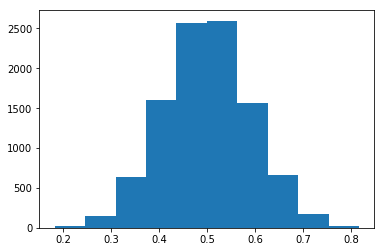

In [0]:
plt.hist(simulated_data)

## distribution of a slope

Here we do the same wirh an OLS regression.

TODO: add more text

In [0]:
N_simulations = 10000
sample_size = 100
slope = 0.5
constant = 1.0
noise = 0.1
simulated_x = tf.random.normal([N_simulations,sample_size])
simulated_y = constant + slope * simulated_x + noise*tf.random.normal([N_simulations,sample_size])





In [0]:
constants = []
slopes = []

for i in range(N_simulations):
  model = sm.OLS(simulated_y[i,:].numpy(), sm.add_constant(simulated_x[i,:].numpy()))
  results = model.fit().params
  constants.append(results[0])
  slopes.append(results[1])

We can derive the distributions of slopes:

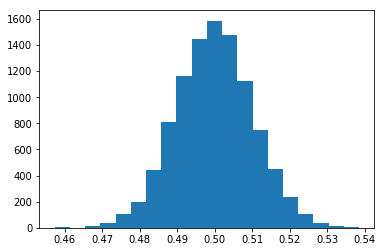

In [0]:
plt.hist(slopes,bins=20)
plt.show()

and the distribution of the constants:

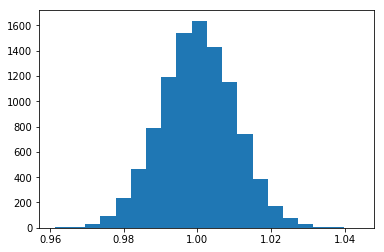

In [0]:
plt.hist(constants,bins=20)
plt.show()

We can plot the lines that are induced by these distributions of the constant and the slope

TODO: add more text

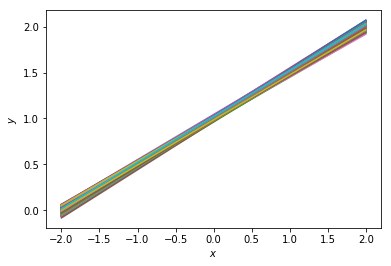

In [0]:
for i in range(1000):
  plt.plot([-2,2],[constants[i]+slopes[i]*(-2),constants[i]+slopes[i]*(2)])
  
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# Bootstrapping

Sometimes we do not know what the underlying model is that generated the data. We only have the sample that we observed.  How do we proceed in this case?


Suppose that we have two populations (e.g. men vs women; or in the test of a new drug: patients that got the treatment and patients that received the placebo). Denote these two samples by $A$ and $B$. 



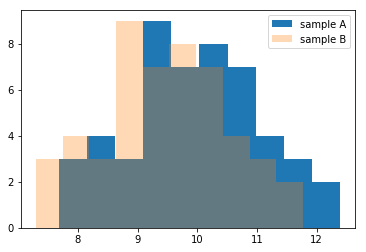

In [0]:
sample_size = 50
delta = 0.95
A = 10+tf.random.normal([sample_size])
B = A*delta
plt.hist(A,label='sample A')
plt.hist(B,alpha=0.3,label='sample B')
plt.legend()

We find that the average of $A$ is higher than the average of $B$, but is this a significant effect (forget for a second that you saw the code generating the data)?


In [0]:
observed_difference = np.mean(A)-np.mean(B)
print(observed_difference)

0.4984522


In your statistics class you have seen a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to figure out whether this difference is significant or not. But we are going to use simulations to establish this.

The null hypothesis that we want to test is: samples $A$ and $B$ are drawn from the same distribution.

If this is true, than we can simply combine the $A$ and $B$ observations, reshuffle them and calculate the difference. We do this 10,000 times and get a distribution of the difference



In [0]:
AB = tf.concat([A,B],axis=0).numpy()

In [0]:
differences = []

for i in range(10000):
  np.random.shuffle(AB)
  differences.append(np.mean(AB[:sample_size])-np.mean(AB[sample_size:]))
                             
                      

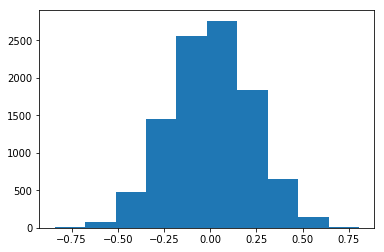

In [0]:
plt.hist(differences)
plt.show()

In [0]:
sum(differences>observed_difference)/len(differences)

0.0119

# Doing your own OLS

There exist many packages that can do OLS for you. But it is illustrative, to program your own OLS estimator, because then you can see what it does.

We start really simple and through the lecture we are going to make the estimator more sophisticated.

For OLS, we could just substitute the solution using matrix algebra: $\beta = (x^Tx)^{-1}x^Ty$. But we want to use the optimization problem itself so that we can add things to it later on.

First, we are going to generate our own data.

Then we define a loss function (mean squared error) and minimize the loss by choosing a constant (`w[0]`) and slope (`w[1]`).

In [14]:
sample_size = 500
slope = -3.0
constant = 1.0
x = tf.random.normal([sample_size])
y = slope*x+constant+3*tf.random.normal([sample_size])

def loss(w):
  return np.sum((w[0]+w[1]*x-y)**2)/len(y)

optimize.fmin(loss, [0,0])

Optimization terminated successfully.
         Current function value: 8.900007
         Iterations: 71
         Function evaluations: 143


array([ 1.07611746, -3.09177618])

# Causality

The data we generate is inspired by [Richard McElreath
's lecture 6](https://www.youtube.com/watch?v=l_7yIUqWBmE). 

As you know, multiple regression is about correlations, not about causality. When looking at the results of a multiple regression, there are a number of mistakes that you can make. Here we are going to look at four of these mistakes:

* the fork
* the pipe
* the collider
* the descendant

## The fork

To be added

## The pipe

To be added

## The collider

Many people have the intuition that adding a control variable to a regression (especially when it turns out to be signficant) is a good idea. However, this intuition is wrong if it is applied without thinking.

We use here the education example by Richard McElreath to illustrate this point. Consider the educational achievements of three generations in one family: the grandparent, the parent and the (grand)child. We are interested in the effect of the grandparent's education on the educational achievement of the grandchild. 

Let's denote the child's educational achievement by $Y$ (the variable we are interested in) and the grandparent's education $X$. We want to understand the effect of $x$ on $Y$. Clearly there is the following path: more educated grandparent leads to more educated parent which, in turn, leads to more educated grandchild. The thing we are interested in is whether there is a direct effect from the grandparent on the child, *controlling* for the parent's education.

We know that the parent's education has a positive effect on the child's achievement. A more educated parent will tend to stimulate their children more, can help with homework etc. In the data that we generate below, we assume that $Z = X + ...$ and $Y = Z + ...$. That is, we assume that the parent's education feeds one-to-one into the child's education. 

Is it the case that on top of this effect there is a separate grandparent effect? E.g. because the grandparent is babysitting and a more educated grandparent reads Hamlet with the 5 year old grandchild. That is fun and can boost the child's educational achievement.

Another important component of education is the neighborhood where the child grows up. We denote this variable $U$. In the code we assume that the parent and child grow up in the same neighborhood (have the same $U$ effect).  $U$ is drawn from a standard normal distribution and the effect on education is given through a multiplication by the factor `alpha`.

In addition to this, we assume that there is a random component as well which differs between parent and child.

The code below, generates this data and a dataframe `df` that stores this data.

Look carefully at the code: is there a direct effect from the grandparent to the grandchild's educational achievement?

We generate two dataframes: `df` is the one that is observed and used in the analysis by the researcher. 

We will use `df_2` to illustrate why one can get incorrect results from analyzing `df`. The problem is that the researcher does not have access to `df_2` but we can analyze `df_2` for "educational purposes" to illustrate why problems arise.

In [0]:
N_observations = 5000
alpha = 0.5
X = tf.random.normal([N_observations])
U = tf.random.normal([N_observations])
Z = X + alpha*U+0.4*tf.random.normal([N_observations])
Y = Z + alpha*U+0.4*tf.random.normal([N_observations])

df = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
df_2 = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z, 'U':U})
print(df.head())
print(df_2.head())

          X         Y         Z
0  0.457851  1.265055  0.940825
1  1.055398 -0.392293 -0.093608
2  2.285888  2.527209  2.845929
3  0.056958 -0.177552 -0.538625
4 -0.296222 -0.257734 -0.601758
          X         Y         Z         U
0  0.457851  1.265055  0.940825  0.819923
1  1.055398 -0.392293 -0.093608 -0.971262
2  2.285888  2.527209  2.845929  0.039775
3  0.056958 -0.177552 -0.538625  0.142526
4 -0.296222 -0.257734 -0.601758  0.001852


To find the (direct) effect of the grandparent ($X$) and the grandchild's educational achievement ($Y$) conditional on the parent ($Z$), we use multiple regression where both $x$ and $Z$ are used as explanatory variables:

In [0]:
results = smf.ols('Y ~ X + Z', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 2.123e+04
Date:                Thu, 25 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:37:46   Log-Likelihood:                -3648.4
No. Observations:                5000   AIC:                             7303.
Df Residuals:                    4997   BIC:                             7322.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.007     -0.028      0.9

The effect of the grandparent's educational achievement ($X$) on the child's achievement is negative and significant. Where does that come from? How is this even possible?

If we consider the direct effect of $X$ on $Y$ it is --as expected-- positive and significant:

In [0]:
results2 = smf.ols('Y ~ X', data=df).fit()
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     3744.
Date:                Thu, 25 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:37:48   Log-Likelihood:                -7877.8
No. Observations:                5000   AIC:                         1.576e+04
Df Residuals:                    4998   BIC:                         1.577e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0042      0.017      0.253      0.8

To see what is happening here in a graph, let's think about what it means to "control for parental education $Z$". 

To visualize what happens, we condition on $Z$ by focusing on a narrow band of $Z$ observations. In other words, we condition on $Z$ by focusing on a subsample where the $Z$ values are (almost) the same. We do this by creating a column `selected` in our dataframe.

In [0]:
df['selected'] = np.abs(df.Z)<0.05

In [0]:
df.head()

,X,Y,Z,selected
0,0.457851,1.265055,0.940825,False
1,1.055398,-0.392293,-0.093608,False
2,2.285888,2.527209,2.845929,False
3,0.056958,-0.177552,-0.538625,False
4,-0.296222,-0.257734,-0.601758,False


Feel free to make this plot using `matplotlib`. For fun, we use `altair` here. 

The blue circles are all the data, the orange ones are the data with (almost) the same $Z$.

**Question** Give the intuition why there is a negative correlation between $X$ and $Y$ with the orange dots. [hint: what do you know about orange dots with low $X$ and about orange dots with high $X$?]

If you cannot answer this question yet, consider the following interactive graph.



In [0]:

alt.Chart(df).mark_point().encode(
  x='X',
  y='Y',
  color='selected'
).interactive()

Chart({
  data:              X         Y         Z  selected
  0     0.457851  1.265055  0.940825     False
  1     1.055398 -0.392293 -0.093608     False
  2     2.285888  2.527209  2.845929     False
  3     0.056958 -0.177552 -0.538625     False
  4    -0.296222 -0.257734 -0.601758     False
  5    -0.341626 -1.904680 -1.304550     False
  6     0.021566  1.301303  0.395192     False
  7    -0.454058 -2.163214 -1.215832     False
  8     0.895082  2.083627  1.064359     False
  9    -0.102254 -0.387618 -0.494498     False
  10    0.880064  1.591462  1.296055     False
  11    0.929998 -0.791414 -0.387643     False
  12    0.930664  0.483053  0.586196     False
  13    0.306817  2.016668  1.216282     False
  14   -1.468740 -2.112158 -1.903444     False
  15    1.166930  2.579175  2.306873     False
  16    1.779604  2.673040  1.936559     False
  17    0.028714 -0.226489  0.203680     False
  18   -0.076571  0.384487  0.017145      True
  19    0.325518  1.519441  0.630749     False
  20   -1.340274 -3.263646 -2.078695     False
  21   -0.158037  0.599055  0.353672     False
  22   -1.228187 -0.971813 -1.038303     False
  23    0.764724  1.765927  1.391503     False
  24   -1.001767  0.446220 -0.177108     False
  25    0.598440  0.748305  0.495636     False
  26   -0.155819  1.235528  0.434728     False
  27    0.865444  0.541837  0.753321     False
  28    0.810287  1.523479  0.947049     False
  29   -1.934896 -3.085159 -2.510747     False
  ...        ...       ...       ...       ...
  4970  2.316738  1.464328  2.256784     False
  4971 -1.110414 -1.868791 -1.036314     False
  4972 -1.982279 -3.088326 -2.402140     False
  4973 -0.257706  1.484512  0.906647     False
  4974  2.061145  3.349252  2.749485     False
  4975 -0.210457 -0.794966 -0.433709     False
  4976  1.250912  1.037061  0.949848     False
  4977  0.660520  0.393879  0.988250     False
  4978  0.567184  1.425610  1.433416     False
  4979 -2.729229 -3.983743 -3.339807     False
  4980  0.812138  0.902223  0.982503     False
  4981  0.532461  3.275263  2.287923     False
  4982 -0.204920 -0.124279 -0.415546     False
  4983 -2.003721 -4.034664 -2.705987     False
  4984  0.291680 -1.436959 -0.892650     False
  4985  0.201513  2.648007  1.407097     False
  4986 -1.927785 -1.085983 -0.837245     False
  4987  0.410936  0.746718  0.779459     False
  4988 -0.728280  1.048951 -0.218778     False
  4989  0.554238 -0.232615  0.350759     False
  4990 -0.709680  1.067427  0.148617     False
  4991 -0.236878 -2.032114 -1.389217     False
  4992  0.482936 -1.048066 -0.406908     False
  4993 -0.719472  0.253118 -0.741146     False
  4994  0.148462 -0.448234 -0.419445     False
  4995  0.491381  1.778602  0.842716     False
  4996 -0.335721 -0.630750 -0.622127     False
  4997  0.522794 -0.433261 -0.199489     False
  4998 -0.498939 -1.025162 -1.238478     False
  4999 -0.094347 -0.793043 -0.288375     False
  
  [5000 rows x 4 columns],
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'selected'
    }),
    x: X({
      shorthand: 'X'
    }),
    y: Y({
      shorthand: 'Y'
    })
  }),
  mark: 'point',
  selection: SelectionMapping({
    selector017: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})

To better understand what is happening here, we are going to use `df_2`. In particular, in the combined figure below, we again provide a scatter plot of `X` vs `Y`. Now the color indicates the level of `Z` associated with the observation; darker colors indicate higher values of `Z`. The size of the point (circle) indicates the level of `U` (that the researcher cannot see in `df`). 

To condition on `Z` (as we do in a multiple regression), we can drag a rectangle in the bottom histogram. Move this histogram around and see what happens. In particular:
* how does `Z` vary in the figure? E.g. where are the high values of `Z`? What is the interpretation of this?
* for a selection of `Z` in the bottom histogram, what is the relation between `X` and `Y`?
* for this selection, how does `U` vary in the figure? What is the interpretation?


**Question** Give the intuition why there is a negative correlation between `X` and `Y` for a selection of `Z`; that is, conditional on `Z`.

**Exercise** What is the risk of saying: I have run a regression and controlled for all effects that I had variables for?

In [0]:
interval = alt.selection_interval(encodings=['y'])

fig = alt.Chart(df_2).mark_point().encode(
  x='X',
  y='Y',
  color=alt.condition(interval, 'Z', alt.value('lightgreen')),
  size = 'U'
).properties(
    selection=interval

)



hist = alt.Chart(df_2).mark_bar().encode(
    x='count()',
    y=alt.Y('Z',bin=True),
    color=alt.condition(interval, 'Z', alt.value('lightgrey'))
).properties(
    selection=interval

)

fig & hist

VConcatChart({
  vconcat: [Chart({
    data:              X         Y         Z         U
    0     0.457851  1.265055  0.940825  0.819923
    1     1.055398 -0.392293 -0.093608 -0.971262
    2     2.285888  2.527209  2.845929  0.039775
    3     0.056958 -0.177552 -0.538625  0.142526
    4    -0.296222 -0.257734 -0.601758  0.001852
    5    -0.341626 -1.904680 -1.304550 -0.380424
    6     0.021566  1.301303  0.395192  0.658308
    7    -0.454058 -2.163214 -1.215832 -1.822392
    8     0.895082  2.083627  1.064359  0.810356
    9    -0.102254 -0.387618 -0.494498  0.448674
    10    0.880064  1.591462  1.296055  0.435158
    11    0.929998 -0.791414 -0.387643 -2.014086
    12    0.930664  0.483053  0.586196 -1.011628
    13    0.306817  2.016668  1.216282  1.365830
    14   -1.468740 -2.112158 -1.903444 -0.320922
    15    1.166930  2.579175  2.306873  0.899936
    16    1.779604  2.673040  1.936559  0.005484
    17    0.028714 -0.226489  0.203680 -0.247177
    18   -0.076571  0.384487  0.017145  0.309863
    19    0.325518  1.519441  0.630749  1.307918
    20   -1.340274 -3.263646 -2.078695 -2.220545
    21   -0.158037  0.599055  0.353672  0.456867
    22   -1.228187 -0.971813 -1.038303  0.697273
    23    0.764724  1.765927  1.391503  0.972202
    24   -1.001767  0.446220 -0.177108  0.339433
    25    0.598440  0.748305  0.495636 -0.007668
    26   -0.155819  1.235528  0.434728  0.464266
    27    0.865444  0.541837  0.753321 -0.409514
    28    0.810287  1.523479  0.947049 -0.098383
    29   -1.934896 -3.085159 -2.510747 -1.175111
    ...        ...       ...       ...       ...
    4970  2.316738  1.464328  2.256784  0.346335
    4971 -1.110414 -1.868791 -1.036314 -0.506663
    4972 -1.982279 -3.088326 -2.402140 -0.502929
    4973 -0.257706  1.484512  0.906647  1.081818
    4974  2.061145  3.349252  2.749485  0.669264
    4975 -0.210457 -0.794966 -0.433709 -0.647537
    4976  1.250912  1.037061  0.949848 -0.197711
    4977  0.660520  0.393879  0.988250 -0.400431
    4978  0.567184  1.425610  1.433416  0.411706
    4979 -2.729229 -3.983743 -3.339807 -0.549274
    4980  0.812138  0.902223  0.982503  0.876848
    4981  0.532461  3.275263  2.287923  1.492574
    4982 -0.204920 -0.124279 -0.415546 -0.479266
    4983 -2.003721 -4.034664 -2.705987 -0.988444
    4984  0.291680 -1.436959 -0.892650 -1.309173
    4985  0.201513  2.648007  1.407097  1.489840
    4986 -1.927785 -1.085983 -0.837245  0.365595
    4987  0.410936  0.746718  0.779459  0.128400
    4988 -0.728280  1.048951 -0.218778  0.445816
    4989  0.554238 -0.232615  0.350759 -1.735953
    4990 -0.709680  1.067427  0.148617  0.756830
    4991 -0.236878 -2.032114 -1.389217 -1.272771
    4992  0.482936 -1.048066 -0.406908 -1.063554
    4993 -0.719472  0.253118 -0.741146  1.341945
    4994  0.148462 -0.448234 -0.419445 -1.002585
    4995  0.491381  1.778602  0.842716  1.307643
    4996 -0.335721 -0.630750 -0.622127  0.309564
    4997  0.522794 -0.433261 -0.199489 -1.220293
    4998 -0.498939 -1.025162 -1.238478  0.096184
    4999 -0.094347 -0.793043 -0.288375  0.490880
    
    [5000 rows x 4 columns],
    encoding: EncodingWithFacet({
      color: ColorValue({
        condition: Color({
          selection: 'selector039',
          shorthand: 'Z'
        }),
        value: 'lightgreen'
      }),
      size: Size({
        shorthand: 'U'
      }),
      x: X({
        shorthand: 'X'
      }),
      y: Y({
        shorthand: 'Y'
      })
    }),
    mark: 'point',
    selection: NamedSelection({
      selector039: SelectionDef({
        encodings: ['y'],
        type: 'interval'
      })
    })
  }), Chart({
    data:              X         Y         Z         U
    0     0.457851  1.265055  0.940825  0.819923
    1     1.055398 -0.392293 -0.093608 -0.971262
    2     2.285888  2.527209  2.845929  0.039775
    3     0.056958 -0.177552 -0.538625  0.142526
    4    -0.296222 -0.257734 -0.601758  0.001852
    5    -0.341626 -1.904680 -1.304550 -0.380424
    6     0.021566  1.3

## The descendant


In the three cases above, it sometimes happens that you do not have data on $Z$, but you have data on a variable $A$ correlated with $Z$. This is called a descendant.

To be added

# IV

What are instrumental variables again?

We use the IV example in [Richard McElreath's lecture 18
](https://www.youtube.com/watch?v=e5cgiAGBKzI) (starting around 28:00).

An individual's education (`e`) affects her wage (`w`). We want to know how strong this effect is.

`q` denotes fraction of the year that has elapsed when you were born.

**TODO** add text






In [0]:
N_observations=200
alpha_w = 1.
beta_ew = 0.
alpha_e = 1.
beta_qe = 2.
q = tf.random.uniform([N_observations])
u = tf.random.normal([N_observations])
e = alpha_e + beta_qe*q + u + tf.random.normal([N_observations])
w = alpha_w + beta_ew*e + u + tf.random.normal([N_observations])
df = pd.DataFrame({'q':q,'e':e,'w':w})

In [55]:
results = smf.ols('w ~ e', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     99.72
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           2.82e-19
Time:                        13:06:03   Log-Likelihood:                -326.95
No. Observations:                 200   AIC:                             657.9
Df Residuals:                     198   BIC:                             664.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2576      0.149     -1.731      0.0

In [56]:

mod = IV2SLS.from_formula('w ~ 1 + [e ~ q]', df)

iv_res = mod.fit()
iv_res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      w   R-squared:                      0.0053
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0003
No. Observations:                 200   F-statistic:                    0.0003
Date:                Sat, Apr 27 2019   P-value (F-stat)                0.9873
Time:                        13:06:04   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.9297     0.6074     1.5306     0.1259     -0.2608      2.1202
e              0.0046     0.2858     0.0160     0.9873     -0.5556      0.5648
==============================================================================

Endogenous: e
Instruments: q
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f1f8a18b630

In [57]:
iv_res.first_stage

,e
R-squared,0.0603
Partial R-squared,0.0603
Shea's R-squared,0.0603
Partial F-statistic,15.102
P-value (Partial F-stat),0.0001
Partial F-stat Distn,chi2(1)
==========================,==========
Intercept,1.3497
,(6.3120)
q,1.3879


# Some background on tensors

We will have a technical interlude to explain what tensors are and what you can do with them. We describe some functions that can be applied to tensors. To motivate these functions, we will build our first neural network. The point here is not so much to explain how neural networks works but more to show you that the functions we consider are going to be useful later on when we will try to understand neural networks more deeply.

## Tensors

In most of the empirical analyses that you have done, an observation is a one dimensional vector. E.g. you have data on inflation, unemployment, gdp growth for country-year combinations. Then for the UK in 2000, our data  consists of the one dimensional vector `[inflation, unemployment, gdp growth]`. If you have 100 observations like this, you can represent them in a matrix. Each row is an observation and the columns will be `[coutry, year, inflation, unemployment, gdp growth]`. Hence we have a two dimensional dataset with 100 rows and 5 columns.

In big data, there are usually higher dimension observations. One of the "classic" datasets in machine learning is [the MNIST dataset.](https://en.wikipedia.org/wiki/MNIST_database) This dataset consists of handwritten numbers and their corresponding label (e.g. when the handwritten number is 5, the label for this image `5`). We will see an example shortly.

The point is that a handwritten number is a two dimensional observation. To illustrate this, consider the 5th image from the training dataset (python starts numbering at 0); we plot the handwritten image (which is 2 dimensional) and print its label.



In [59]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


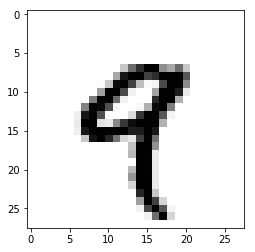

9


In [60]:
plt.imshow(train_images[4],cmap=plt.cm.binary)
plt.show()
print(train_labels[4])

Indeed, the handwritten number is 9, which equals its label.

What are the dimensions for this dataset. Let's use `shape` to find out:

In [0]:
train_images.shape

(60000, 28, 28)

In [0]:
train_images[0].shape

(28, 28)

## Tensors in numpy

Well known machine learning backends are Theano and Tensorflow. For reasons that we do not worry about here, these are not immediately straightforward to work with. But we can play around with dimensions in Numpy as well. Properties that we can use in Numpy, like broadcasting, can be used in Theano and Tensorflow as well.

As Numpy is "more direct" to work with, we will practice this with numpy.

First, we create the vector `x` with 100 random numbers. 

In [0]:
x = np.random.normal(0,1,size=100)

We can check what the shape is of this vector:

In [0]:
x.shape

(100,)

and the vector is one-dimensional from a tensor point of view:

In [0]:
x.ndim

1

**No not read this if you get easily confused:** If you would plot the vector `x` it would be a *vector* in a 100-dimensional space. Hence it is a 100 dimensional vector, but a 1 dimensional tensor.


Let us know consider a two dimensional (2D) tensor. This is what we usually call a matrix

In [0]:
x2 = x.reshape(25,4)

In [0]:
x2.ndim

2

In [0]:
x2.shape

(25, 4)

In matrix terminology we would say that `x2` has 25 rows and 4 columns.

A 3D tensor is then

In [0]:
x3 = x.reshape(4,5,5)

In [0]:
x3.ndim

3

In [0]:
x3.shape

(4, 5, 5)

One way to think about this is as four $5*5$ images.

The numpy representation of this is as follows:

In [0]:
x3

array([[[-1.03240029, -0.57335027, -0.37878829,  0.33853161,
         -0.77772049],
        [-0.11758745, -1.83588812,  0.47377698,  0.51546888,
          1.05193605],
        [ 0.56830483, -0.44499826,  1.77480227, -0.34977874,
         -1.1809494 ],
        [-0.07258114,  0.38596716,  0.74721885,  0.77705278,
          0.04235153],
        [-0.72859423, -0.15379448,  0.41996278,  0.07859223,
         -0.32542562]],

       [[ 0.04395014,  1.01914645, -1.8287077 ,  1.07169056,
          1.40403043],
        [ 0.61288627,  0.02337423,  0.0323521 ,  1.34857526,
         -0.73226028],
        [ 0.92091378,  2.05867972, -0.24622676,  1.25385274,
         -0.33353183],
        [-0.96209565, -0.07018719,  0.13891353,  1.0818914 ,
         -0.521243  ],
        [ 1.70230309,  1.81196586, -0.65173351, -0.96987927,
         -1.76164139]],

       [[-0.42135903, -1.93228048, -1.23060014,  0.05179087,
         -0.76828035],
        [-1.54407761, -0.94383985,  0.0627806 , -1.03624688,
          1

we can also add a dimension to a vector without adding or re-arranging data. For this we use `np.newaxis`

In [0]:
x4 = x3[:,:,:,np.newaxis]

In [0]:
x4.ndim

4

In [0]:
x4.shape

(4, 5, 5, 1)

Now you may wonder why this is a useful thing to do.

## Broadcasting

Suppose you have estimated a fixed effect model. In your data there are i = 0,1,...,9 individuals and t = 0,1,2 periods. The vector `I` consists of 10 individual fixed effects and the vector `T` has 3 time fixed effects. Hence, our prediction for indiv. `i` in time period `t` (ignoring other explanatory variables) is $y_{it}=I_i+T_t$. 

How can we calculate the vector `y`?

We first give you the answer using broadcasting and then we step back to explain what broadcasting is.




In [0]:
I = np.arange(10)
T = np.arange(0,30,10)

In [0]:
I

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
T

array([ 0, 10, 20])

Because of the simplistic numbers that we have chosen, it is easy to see that e.g. $y_{31} = 13$ with $i=3$ and $t=1$. So we can check whether our trick works.

In [0]:
y = I[:,np.newaxis]+T[np.newaxis,:]

In [0]:
y

array([[ 0, 10, 20],
       [ 1, 11, 21],
       [ 2, 12, 22],
       [ 3, 13, 23],
       [ 4, 14, 24],
       [ 5, 15, 25],
       [ 6, 16, 26],
       [ 7, 17, 27],
       [ 8, 18, 28],
       [ 9, 19, 29]])

In [0]:
I[:,np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [0]:
T[np.newaxis,:]

array([[ 0, 10, 20]])

What is going on here?

## Slicing and reshape

## First neural network

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [64]:
model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 5s 78us/sample - loss: 2.8787 - accuracy: 0.8544
Epoch 2/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.3819 - accuracy: 0.9096
Epoch 3/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2785 - accuracy: 0.9290
Epoch 4/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2462 - accuracy: 0.9377
Epoch 5/5
60000/60000 [==============================] - 4s 75us/sample - loss: 0.2263 - accuracy: 0.9412


In [65]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)


10000/10000 [==============================] - 0s 42us/sample - loss: 0.2516 - accuracy: 0.9409

Test accuracy: 0.9409


In [67]:
predictions = model.predict(test_images)
predictions[0]

array([9.8176270e-23, 7.6727825e-12, 4.8534746e-11, 1.4946133e-10,
       1.8974962e-19, 2.2767677e-17, 1.4859478e-31, 1.0000000e+00,
       1.7036403e-13, 3.5619310e-13], dtype=float32)

In [68]:
np.argmax(predictions[0])


7

In [69]:
test_labels[0]


7

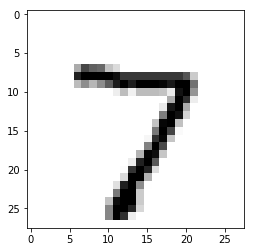

In [70]:
plt.imshow(test_images[0],cmap=plt.cm.binary)
plt.show()

## Functions

What is `relu` and `softmax`? What does `adam` mean?


In [0]:
np.maximum(z,0)

In [19]:
np.relu(10,0)

AttributeError: ignored

In [0]:
np.dot

# Overfitting and underfitting


Adding more explanatory variables to a regression cannot make the fit worse. This is easy to see: if it would become worse, you would set the coefficient on the added variables to 0. That would give the same fit as before. In real applications that may not be completely true as there is often randomness in the routines that are being used.

underfitting is ...

overfitting is ...


So how can we choose what the right model is?

A simple idea is cross validation. This idea is seen a lot in data science. Here we consider a simple example to illustrate cross validation.






## Regression in tensorflow

Below we will run regressions for a number of models. To understand what happens, let us first run a simple regression to see what the syntax looks like.

There are a number of python packages with which you can do a regression analysis. For example, [statsmodels](https://www.statsmodels.org/stable/index.html) has a nice syntax and by default returns things like t-values etc. If you just need to run a regression or two, than this is a great choice.

But if we want to program a series of regressions, tensorflow or [scikit-learn](https://scikit-learn.org/stable/index.html) are more useful as they are easier to program.

Here we use tensorflow.

First, we generate some simple data and add these to a dataframe.






In [0]:
N_observations = 50
train_size = 25
x = tf.random.normal([N_observations])
y = 3*x+5*tf.random.normal([N_observations])
df = pd.DataFrame({'y':y,'x':x})
df['constant'] = 1


In [0]:
features = ['constant','x']

y_train = df['y'][:train_size]
y_test =  df['y'][train_size:]

In [0]:
def make_input_fn(data_df, label_df, num_epochs=10, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [0]:
df_train = df[features][:train_size]
df_test = df[features][train_size:]
NUMERIC_COLUMNS = features
feature_columns = []
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn = make_input_fn(df_test, y_test)
  
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
linear_est.train(train_input_fn)

W0426 11:00:41.042322 140661382256512 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpg81_wxt6


In [0]:
linear_est.evaluate(train_input_fn)


{'average_loss': 53.268085,
 'global_step': 10,
 'label/mean': -1.5691618,
 'loss': 53.26809,
 'prediction/mean': -1.3206078}

## Series of regressions


To illustrate overfitting, we construct a dataset, generating $y$ values from some $x$ vector

In [0]:
N_observations = 50
train_size = 25
x = tf.random.normal([N_observations])
y = 100*x+np.cos(x)-4*np.exp(x)+x**2+x**5-x**3+55*tf.random.normal([N_observations])
df = pd.DataFrame({'y':y,'x':x})
df['constant'] = 1
df['x2'] = df.x**2
df['x3'] = df.x**3
df['x4'] = df.x**4
df['x5'] = df.x**5
df['x6'] = df.x**6
df['x7'] = df.x**7
df['x8'] = df.x**8
df['x9'] = df.x**9
df['x10'] = df.x**10


In [0]:
features = ['constant','x','x2','x3','x4','x5','x6','x7','x8','x9','x10']

y_train = df['y'][:train_size]
y_test =  df['y'][train_size:]

In [0]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=False, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function


In [0]:
def make_input_fn(data_df, label_df, num_epochs=10, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_score = []
test_score = []
number_features = []

for i in range(2,len(features)+1):
  df_train = df[features[:i]][:train_size]
  df_test = df[features[:i]][train_size:]
  NUMERIC_COLUMNS = features[:i]
  feature_columns = []
  for feature_name in NUMERIC_COLUMNS:
      feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
      
  train_input_fn = make_input_fn(df_train, y_train)
  eval_input_fn = make_input_fn(df_test, y_test)
  
  linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
  linear_est.train(train_input_fn)
  
  print(i)
  number_features.append(i)
  train_score.append(linear_est.evaluate(train_input_fn)['average_loss'])
  test_score.append(linear_est.evaluate(eval_input_fn)['average_loss'])
  
   


W0412 15:07:13.493996 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpjs_vp1aj


2


W0412 15:07:16.255155 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpfr4rgkbc


3


W0412 15:07:19.462801 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp6sj72882


4


W0412 15:07:22.969622 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp80h53n31


5


W0412 15:07:26.521700 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp0s2h2_jv


6


W0412 15:07:30.688949 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpjqlym828


7


W0412 15:07:35.339830 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp_fij2cys


8


W0412 15:07:40.202742 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpo4h6n5nh


9


W0412 15:07:45.368536 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp0so1pi4a


10


W0412 15:07:51.150089 140171793852288 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpryftodpb


11


In [0]:
outcome = pd.DataFrame({'x_i':number_features, 'train_score': train_score, 'test_score': test_score})  
outcome

,test_score,train_score,x_i
0,1.926601e+04,9878.484375,2
1,1.966035e+04,9865.999023,3
2,1.843711e+04,9697.901367,4
3,2.097978e+04,9690.875977,5
4,1.328872e+04,9397.949219,6
5,2.144416e+04,9399.768555,7
6,4.281177e+04,8876.856445,8
7,4.185888e+04,8876.468750,9
8,6.541792e+06,8024.864258,10
9,6.001704e+06,8024.195312,11


The following graph shows that adding more terms $x^a$ always helps to get a better fit on the training data. The loss measure falls as we add more terms.

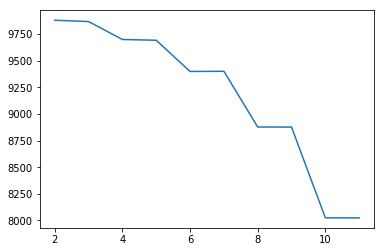

In [0]:
plt.plot(range(2,12),outcome.train_score)


But this is not the case with the test data. We fitted the model on the training data. Now we consider how well the model predicts "out-of-sample" on the test data. Adding 6 terms helps to predict on the test data. However, with more terms added to the model, the model starts to pick up features that are specific to our sample in the training data. These features are nor general to the underlying process. Hence, our loss increases on the test data.

By adding more than 6 terms, we start to overfit in this example.

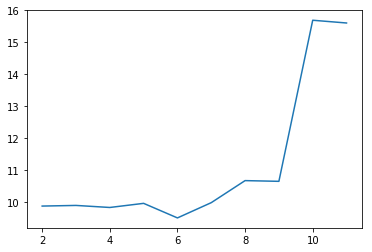

In [0]:
plt.plot(range(2,12),np.log(outcome.test_score))


# OLS using Tensorflow

Using more functionality from Tensorflow to program our OLS.

This allows us to see some building blocks that we will need below to program our neural network.

# Program your own Lasso

With OLS, adding variables is always "good" in terms of in-sample fit. But it can lead to overfitting. 

One way to avoid overfitting is to introduce a penalty for using more variables. This is the idea of Lasso.

Here you are going to program your own Lasso.




# Cross validation


k-fold cross-validation

# Neural network

# Treatment effects

Machine learning is about predicting outcomes. When the prediction is accurate (out-of-sample) we are happy, almost no matter what the model looks like.

This is different when we are interested in policy advice. 